# Necessary Imports for the whole Project

In [39]:
!pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import numpy as np
from math import*

import dask.dataframe

import gensim
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE


from collections import Counter

import swifter

import warnings
warnings.filterwarnings("ignore")

# About the Dataset

## Data collection
The data comes from a csv file collected on OpenFoodFacts.

In [41]:
#dtype={'brand_owner': 'object',"code":"object","generic_name":"object","packaging_text":"object",
      #"traces":"object","traces_en":"object","traces_tags":"object",'abbreviated_product_name': 'object',
      # 'owner': 'object'}
#ddf=dask.dataframe.read_csv("openfoodfacts.csv",sep="\t",encoding="utf-8",dtype=dtype)[["product_name","main_category","food_groups",
                                                                          #"ingredients_tags","food_groups_tags","categories_tags"]]
#df = ddf.compute()

## Data Cleaning

In [42]:
#df2=df[(df["ingredients_tags"].isnull()==False) & (df["food_groups"].isnull()==False)]
#df2.to_csv('clean_data.csv',index=False)

# Map of Ingredients

## Preparation of the dataset...

In [43]:
df=pd.read_csv("clean_data.csv",encoding="utf-8",engine="python",on_bad_lines='skip')
print(df.shape)
df.head()

(539462, 6)


,product_name,main_category,food_groups,ingredients_tags,food_groups_tags,categories_tags
0,moutarde au moût de raisin,en:mustards,en:dressings-and-sauces,fr:eau-graines-de-teguments-de-moutarde-vinaig...,"en:fats-and-sauces,en:dressings-and-sauces","en:groceries,en:condiments,en:sauces,en:mustards"
1,Nectar d'abricot,en:apricot-nectars,en:sweetened-beverages,"fr:jus-et-puree-d-abricots,en:water,en:sugar,e...","en:beverages,en:sweetened-beverages","en:plant-based-foods-and-beverages,en:beverage..."
2,BAguette bressan,en:baguettes,en:bread,"fr:baguette-bressan-pain-baguette,en:wheat-flo...","en:cereals-and-potatoes,en:bread","en:plant-based-foods-and-beverages,en:plant-ba..."
3,Pâte a tartiner,en:hazelnut-spreads,en:sweets,"fr:noisettes-locales,en:cane-sugar,en:added-su...","en:sugary-snacks,en:sweets","en:spreads,en:breakfasts,en:sweet-spreads,fr:p..."
4,Organic Baby Lima Beans,en:butter-beans,en:vegetables,"en:baby-lima-beans,en:legume,en:lima-bean","en:fruits-and-vegetables,en:vegetables","en:plant-based-foods-and-beverages,en:plant-ba..."


In [44]:
#-- we remove prefix and just keep english words
def clean_prefix(text):
    text=text.split(",")
    temp=[]
    try :
        temp=[i.split(":")[1] for i in text if i.split(":")[0]=="en"]
    except :
        pass
    return temp

dff=df.copy()
dff["main_category"]=dff["main_category"].apply(clean_prefix)
dff["food_groups"]=dff["food_groups"].apply(clean_prefix)
dff["ingredients_tags"]=dff["ingredients_tags"].apply(clean_prefix)
dff["food_groups_tags"]=dff["food_groups_tags"].apply(clean_prefix)
dff["categories_tags"]=dff["categories_tags"].apply(clean_prefix)
dff.head()

,product_name,main_category,food_groups,ingredients_tags,food_groups_tags,categories_tags
0,moutarde au moût de raisin,[mustards],[dressings-and-sauces],[],"[fats-and-sauces, dressings-and-sauces]","[groceries, condiments, sauces, mustards]"
1,Nectar d'abricot,[apricot-nectars],[sweetened-beverages],"[water, sugar, added-sugar, disaccharide]","[beverages, sweetened-beverages]","[plant-based-foods-and-beverages, beverages, p..."
2,BAguette bressan,[baguettes],[bread],"[wheat-flour, cereal, flour, wheat, cereal-flo...","[cereals-and-potatoes, bread]","[plant-based-foods-and-beverages, plant-based-..."
3,Pâte a tartiner,[hazelnut-spreads],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar,...","[sugary-snacks, sweets]","[spreads, breakfasts, sweet-spreads, hazelnut-..."
4,Organic Baby Lima Beans,[butter-beans],[vegetables],"[baby-lima-beans, legume, lima-bean]","[fruits-and-vegetables, vegetables]","[plant-based-foods-and-beverages, plant-based-..."


## ...In anticipation of Word2Vec

In [45]:
flat_list = [item for sublist in dff["ingredients_tags"].values for item in sublist]
count_words=Counter(flat_list)
print("We have ",len(count_words), " distinct words")

We have  140234  distinct words


In [46]:
n=5
filtered_words={k: v for k, v in count_words.items() if v < n}
print("We remove ",len(filtered_words)," words because they occur less than ",n," times")
for k in filtered_words.keys():
    count_words.pop(k, None)

We remove  124229  words because they occur less than  5  times


In [47]:
#-- we remove rare words from each list of ingredients_tags
#-- we use swifter in order to parallelize our code and save some time
words_to_keep=list(count_words.keys())
dff["ingredients_tags"]=dff["ingredients_tags"].swifter.apply(lambda x: [ele for ele in x if ele in count_words]) 

Pandas Apply:   0%|          | 0/539462 [00:00<?, ?it/s]

In [48]:
# remove rows with empty lists
dff=dff[(dff["ingredients_tags"].str.len() != 0) & (dff["main_category"].str.len() != 0)
    & (dff["food_groups"].str.len() != 0) & (dff["food_groups_tags"].str.len() != 0)
    & (dff["categories_tags"].str.len() != 0)
   ]
print("We have ",dff.shape[0]," different products")

We have  477742  different products


In [49]:
#-- we delete products with only one ingredients because word2vec will not learn any context on this list
dff=dff[dff["ingredients_tags"].str.len() !=1]
print("We have now",dff.shape[0]," different products")

We have now 470341  different products


In [50]:
#-- we drop duplicates products
dff=dff.drop_duplicates(subset="product_name")
print("We have now",dff.shape[0]," different products")

We have now 341958  different products


In [51]:
#-- we get all unique words from our dataset
flat_list = [item for sublist in dff["ingredients_tags"].values for item in sublist]
vocab=list(set(flat_list))
print("We have ",len(vocab)," different words")

We have  15918  different words


## Word2Vec model

In [52]:
data=dff["ingredients_tags"].values

#-- vector_size=400 means that for one word, we will have a vector of 400 values
model = gensim.models.Word2Vec(data, min_count = 1, window = 5,size=400)

## Ingredients Similarities

### Using the Word2Vec similarity function: cosine similarity

In [53]:
#-- we show similarity between words with word2vec function
w1='pork-meat'
w2="water"
w3="fat"
w4="cereal"
w5="flour"
print("Cosine similarity between '{}' and '{}' : ".format(w1,w2),
    model.wv.similarity(w1, w2))
     
print("Cosine similarity between '{}' and '{}' : ".format(w1,w3),
      model.wv.similarity(w1,w3))

print("Cosine similarity between '{}' and '{}' : ".format(w1,w4),
      model.wv.similarity(w1,w4))

print("Cosine similarity between '{}' and '{}' : ".format(w1,w5),
      model.wv.similarity(w1,w5))

print("Cosine similarity between '{}' and '{}' : ".format(w2,w3),
      model.wv.similarity(w2,w3))

print("Cosine similarity between '{}' and '{}' : ".format(w2,w4),
      model.wv.similarity(w2,w4))

print("Cosine similarity between '{}' and '{}' : ".format(w2,w5),
      model.wv.similarity(w2,w5))

print("Cosine similarity between '{}' and '{}' : ".format(w3,w4),
      model.wv.similarity(w3,w4))

print("Cosine similarity between '{}' and '{}' : ".format(w3,w5),
      model.wv.similarity(w3,w5))

print("Cosine similarity between '{}' and '{}' : ".format(w4,w5),
      model.wv.similarity(w4,w5))

Cosine similarity between 'pork-meat' and 'water' :  0.13838805
Cosine similarity between 'pork-meat' and 'fat' :  0.015399727
Cosine similarity between 'pork-meat' and 'cereal' :  0.029424114
Cosine similarity between 'pork-meat' and 'flour' :  0.063826084
Cosine similarity between 'water' and 'fat' :  0.024386348
Cosine similarity between 'water' and 'cereal' :  0.116101846
Cosine similarity between 'water' and 'flour' :  0.20720038
Cosine similarity between 'fat' and 'cereal' :  0.04560086
Cosine similarity between 'fat' and 'flour' :  0.05244088
Cosine similarity between 'cereal' and 'flour' :  0.13611381


In [54]:
#-- show most similar words to other words
model.wv.most_similar(["water","salt"],topn=5)

[('sugar', 0.36434251070022583),
 ('brown-sugar', 0.3635022044181824),
 ('cane-sugar', 0.36192190647125244),
 ('disaccharide', 0.3397296369075775),
 ('added-sugar', 0.33419638872146606)]

### Using our own similarity functions - Euclidean, Manhattan, Cosine and Jaccard

In [55]:
#-- we compute our owns similarities between ingredients
def euclidean_distance(x,y):
  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def manhattan_distance(x,y):
  return sum(abs(a-b) for a,b in zip(x,y))

def square_rooted(x):
   return round(sqrt(sum([a*a for a in x])),3)
  
def cosine_similarity(x,y):
 numerator = sum(a*b for a,b in zip(x,y))
 denominator = square_rooted(x)*square_rooted(y)
 return round(numerator/float(denominator),3)

def jaccard_similarity(x,y):
 intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
 union_cardinality = len(set.union(*[set(x), set(y)]))
 return intersection_cardinality/float(union_cardinality)

def all_similarities(x,y,model):
  x=model.wv[x]
  y=model.wv[y]
  print("Manhattan distance : ",manhattan_distance(x,y))
  print("Euclidean distance : ",euclidean_distance(x,y))
  print("Cosine similarity : ",cosine_similarity(x,y))
  print("Jaccard similarity : ",jaccard_similarity(x,y))

all_similarities("water","pork-meat",model)

Manhattan distance :  415.1883170157671
Euclidean distance :  26.210334241379744
Cosine similarity :  0.138
Jaccard similarity :  0.0


## Ingredients Vectorization

In [56]:
#-- we create a dataframe where each word is linked with his vector
d={}
for word in vocab:
    d[word]=model.wv[word]
df_vectors=pd.DataFrame.from_dict(d,orient='index')
df_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
chard-concentrate,-0.002357,0.089060,-0.021687,-0.064474,-0.055572,0.056135,0.071880,-0.041469,-0.071028,-0.167370,...,0.026056,-0.022220,-0.054473,0.107056,-0.086109,-0.024724,-0.061142,-0.149065,0.085347,-0.101484
maiz,0.013400,-0.000525,0.013667,-0.040127,-0.007004,-0.005159,0.003496,-0.006156,-0.019379,-0.041510,...,0.007068,-0.026244,-0.017160,0.010828,0.055859,-0.011125,-0.019461,-0.052718,0.044408,-0.034518
vine-ripened-plum-tomatoes,0.030042,0.020522,0.022708,-0.021863,-0.033282,0.043094,-0.010600,-0.030187,-0.006596,-0.006378,...,-0.032275,-0.023027,-0.008618,0.030619,0.052403,0.039575,0.002110,-0.034596,0.053477,-0.011636
vinaigre-de-vin,0.018786,-0.000929,0.018221,-0.002105,-0.024436,-0.003301,0.003068,-0.028288,0.003175,-0.046442,...,-0.009869,-0.047850,-0.018843,0.039023,0.072971,0.024974,-0.022113,-0.028633,0.036600,-0.025325
vetemjol,0.017615,0.025556,-0.000220,-0.011085,-0.036524,-0.010017,0.021852,-0.025651,-0.023042,-0.055737,...,-0.011371,-0.020952,-0.049007,0.038504,0.081480,0.032858,-0.028177,-0.039430,0.041603,0.002008


In [57]:
print(df_vectors.shape)

(15918, 400)


## Maps of Ingredients

### PCA

In [58]:
#-- we do a PCA on our vectors to reduce dimensions to 2
pca = PCA(n_components=2)
pca_num=pca.fit_transform(df_vectors)

#--Transformation in DataFrame pandas
pca_df = pd.DataFrame({
    "ingredient_name" : df_vectors.index,
    "Dim1" : pca_num[:,0], 
    "Dim2" : pca_num[:,1]
})
pca_df.head()

,ingredient_name,Dim1,Dim2
0,chard-concentrate,0.071795,-0.466696
1,maiz,-0.000914,0.083401
2,vine-ripened-plum-tomatoes,0.066415,0.091784
3,vinaigre-de-vin,-0.004538,0.066492
4,vetemjol,0.045297,0.038809


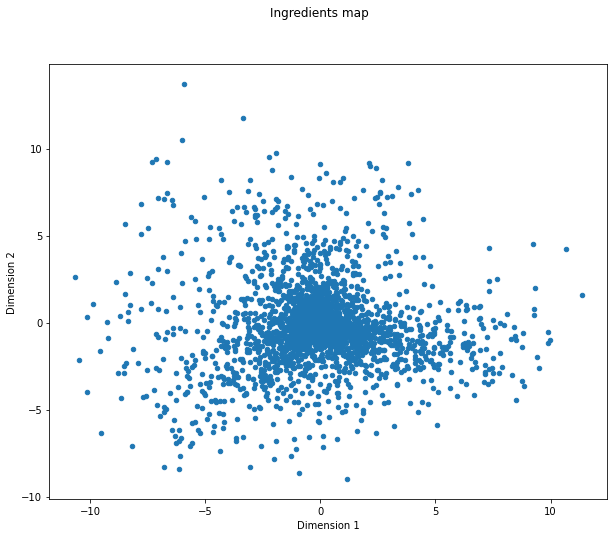

In [59]:
pca_df.plot.scatter("Dim1", "Dim2") #all points
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.suptitle("Ingredients map") # title
fig=plt.gcf()
fig.set_size_inches(10,8)

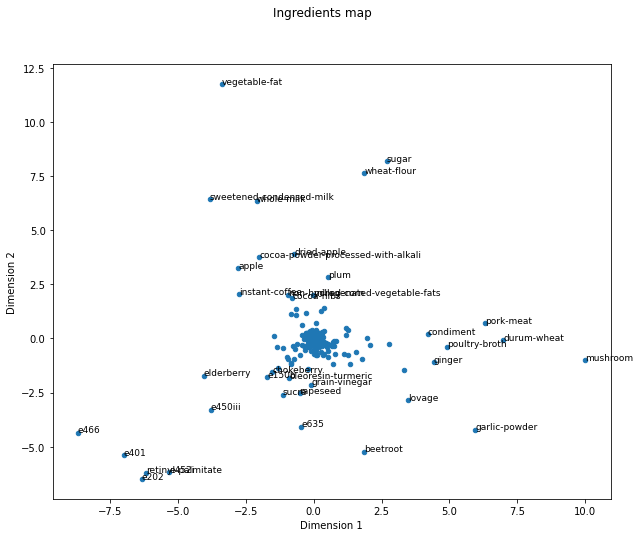

In [60]:
#-- plots with some ingredients names
fig, ax = plt.subplots()
n=500 # we will plot only first n words because there are too much
pca_df[:n].plot.scatter("Dim1", "Dim2", ax = ax) 

#
for k in pca_df[:n].iterrows():
    # we annotate only if values on dimensions are importants
    if (abs(k[1]['Dim1']) > 3.5) | (abs(k[1]['Dim2']) > 1.5):
        ax.annotate(k[1]["ingredient_name"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.suptitle("Ingredients map")
fig=plt.gcf()
fig.set_size_inches(10,8)

### TSNE

In [61]:
tsne_ingredients = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(df_vectors)
tsne_df = pd.DataFrame({
    "ingredient_name" : df_vectors.index,
    "Dim1" : tsne_ingredients[:,0], 
    "Dim2" : tsne_ingredients[:,1]
})

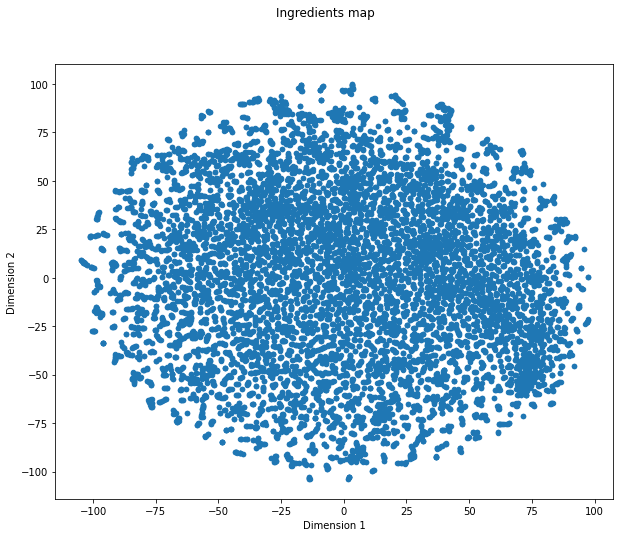

In [62]:
tsne_df.plot.scatter("Dim1", "Dim2") #all points
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.suptitle("Ingredients map") # title
fig=plt.gcf()
fig.set_size_inches(10,8)

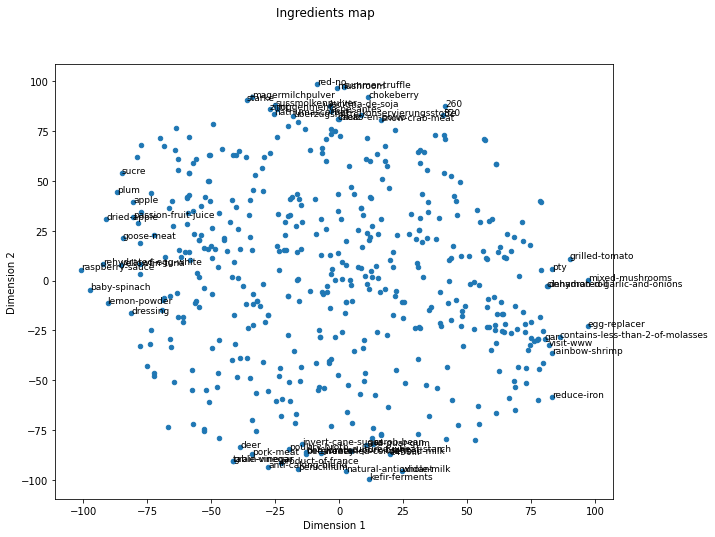

In [63]:
#-- plots with some ingredients names
fig, ax = plt.subplots()
n=500 # we will plot only first n words because there are too much
tsne_df[:n].plot.scatter("Dim1", "Dim2", ax = ax) 

#
for k in tsne_df[:n].iterrows():
    # we annotate only if values on dimensions are importants
    if (abs(k[1]['Dim1']) > 80) | (abs(k[1]['Dim2']) > 80):
        ax.annotate(k[1]["ingredient_name"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.suptitle("Ingredients map")
fig=plt.gcf()
fig.set_size_inches(10,8)

# Comparison between products

## Product similarities: First method

In [74]:
#-- similarities between products (list of ingredients)
def simi_sentences(x,y,model):
  #-- we just keep the first words because there are the most importants one in our product
  if (len(x)>8):
    x=x[:8]
  if (len(y)>8):
    y=y[:8] 
    
  total_words=len(x)*len(y)
  sim=0
  
  #-- we create weights that will be the reverse of positions in the list
  temp=[a+1 for a in range(len(x))][::-1]
  
  #-- we compute cosine_similarity and multiply it by weight between all words of two lists x and y
  sim=round(sum([cosine_similarity(model.wv[x[i]],model.wv[j])*temp[i] for j in y for i in range(len(x)) ]),4)
  
  #-- we devide the result by the number of words in order to have the mean of cosine similarity
  return sim/total_words

simi_sentences(dff["ingredients_tags"].iloc[0],dff["ingredients_tags"].iloc[1],model)

0.4895

In [83]:
dff["ingredients_tags"].iloc[0]

['water', 'sugar', 'added-sugar', 'disaccharide']

In [82]:
dff["ingredients_tags"].iloc[1][:7]

['wheat-flour', 'cereal', 'flour', 'wheat', 'cereal-flour', 'water', 'salt']

In [78]:
dff.head(2)

,product_name,main_category,food_groups,ingredients_tags,food_groups_tags,categories_tags,product_vector
1,Nectar d'abricot,[apricot-nectars],[sweetened-beverages],"[water, sugar, added-sugar, disaccharide]","[beverages, sweetened-beverages]","[plant-based-foods-and-beverages, beverages, p...","[-0.66847223, -0.45306545, -1.3007324, 1.01207..."
2,BAguette bressan,[baguettes],[bread],"[wheat-flour, cereal, flour, wheat, cereal-flo...","[cereals-and-potatoes, bread]","[plant-based-foods-and-beverages, plant-based-...","[-0.2746749, -0.048500545, -0.26304665, -0.192..."


In [86]:
#-- show similarity between a product and the 2000 first products
idx=551
product=dff["ingredients_tags"].iloc[idx]
simi_products=[]
our_range=[x for x in range(2000) if x!=idx]
for i in our_range:
    res=simi_sentences(product,dff["ingredients_tags"].iloc[i],model)
    d={}
    d["name"]=dff["product_name"].iloc[i]
    d['similarity']=res
    d['ingredients']=dff["ingredients_tags"].iloc[i]
    d['main_category']=dff["main_category"].iloc[i]
    simi_products.append(d)
print("Target : ",dff["product_name"].iloc[idx] , product[:7],dff["main_category"].iloc[idx])
pd.DataFrame.from_dict(simi_products).sort_values("similarity",ascending=False)

Target :  Bill Knapp's, Iced Toaster Bread, Cinnamon Raisin ['fortified-wheat-flour', 'cereal', 'flour', 'wheat', 'cereal-flour', 'wheat-flour', 'sugar'] ['breads']


,name,similarity,ingredients,main_category
1121,"Trader joe's, mini pita pockets, wheat",1.209234,"[whole-wheat-flour, cereal, flour, wheat, cere...",[breads]
9,Flute,1.188687,"[wheat, cereal]",[breads]
210,Creamy wheat cereal,1.188687,"[wheat, cereal]",[cereals-and-their-products]
1945,"Bakery fresh goodness, coffee cake, pumpkin spice",1.179437,"[fortified-wheat-flour, cereal, flour, wheat, ...",[cakes]
1735,Two bite cupcakes,1.173437,"[cake, fortified-wheat-flour, cereal, flour, w...",[cakes]
...,...,...,...,...
458,Soft Apricots,-0.455688,"[e220, sulfite]",[dried-apricots]
391,Cherry Spritzer,-0.455688,"[e220, sulfite]",[alcoholic-beverages]
1484,"Kroger, vitamin enhanced water beverage, blood...",-0.463141,"[reverse-osmosis-water, e968, e300, vegetable-...",[waters]
195,Raw Shrimp,-0.590063,"[e339, to-retain-moisture]",[frozen-seafood]


## Product Similarities: Second method

In [66]:
#-- we create product vectors that will be means of all of their ingredients vectors
def sum_vectors(words,model):
    tot=0
    for i in words:
        tot+=model.wv[i]
    return tot/len(words)
dff["product_vector"]=dff["ingredients_tags"].swifter.apply(lambda x : sum_vectors(x,model))
dff.head()

Pandas Apply:   0%|          | 0/341958 [00:00<?, ?it/s]

,product_name,main_category,food_groups,ingredients_tags,food_groups_tags,categories_tags,product_vector
1,Nectar d'abricot,[apricot-nectars],[sweetened-beverages],"[water, sugar, added-sugar, disaccharide]","[beverages, sweetened-beverages]","[plant-based-foods-and-beverages, beverages, p...","[-0.66847223, -0.45306545, -1.3007324, 1.01207..."
2,BAguette bressan,[baguettes],[bread],"[wheat-flour, cereal, flour, wheat, cereal-flo...","[cereals-and-potatoes, bread]","[plant-based-foods-and-beverages, plant-based-...","[-0.2746749, -0.048500545, -0.26304665, -0.192..."
3,Pâte a tartiner,[hazelnut-spreads],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar,...","[sugary-snacks, sweets]","[spreads, breakfasts, sweet-spreads, hazelnut-...","[-0.9610202, -0.063177906, -0.088474154, 0.376..."
4,Organic Baby Lima Beans,[butter-beans],[vegetables],"[baby-lima-beans, legume, lima-bean]","[fruits-and-vegetables, vegetables]","[plant-based-foods-and-beverages, plant-based-...","[0.08436129, -0.6604678, -0.053100724, -0.7921..."
5,Cranberries,[cranberries],[fruits],"[cranberry, fruit, sugar, added-sugar, disacch...","[fruits-and-vegetables, fruits]","[plant-based-foods-and-beverages, plant-based-...","[-0.8712618, -0.1678321, -1.1394557, 0.7019877..."


In [67]:
n=40000
temp=dff.iloc[0:n].copy()
idx=5517
product=dff["product_vector"].iloc[idx]
temp["similarity"]=temp["product_vector"].swifter.apply(lambda x: cosine_similarity(product,x))
print("We compute cosine similarity on ",n," first products for product number ",idx)
print("Target : ",temp["product_name"].iloc[idx] , temp["ingredients_tags"].iloc[idx],temp["main_category"].iloc[idx])
temp.sort_values("similarity",ascending=False).head()

Pandas Apply:   0%|          | 0/40000 [00:00<?, ?it/s]

We compute cosine similarity on  40000  first products for product number  5517
Target :  Dryden & Palmer, Rock Candy Sugar Stick ['cane-sugar', 'added-sugar', 'disaccharide', 'sugar'] ['confectioneries']


,product_name,main_category,food_groups,ingredients_tags,food_groups_tags,categories_tags,product_vector,similarity
14181,Pure cane sugar,[sugars],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar]","[sugary-snacks, sweets]","[sweeteners, sugars]","[-0.82304966, 0.030063733, -1.7676951, 1.00464...",1.0
6758,"Dryden & Palmer, Rock Candy Sugar Stick",[confectioneries],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar]","[sugary-snacks, sweets]","[snacks, sweet-snacks, confectioneries]","[-0.82304966, 0.030063733, -1.7676951, 1.00464...",1.0
48542,Coarse demerara turbinado sugar,[sugars],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar]","[sugary-snacks, sweets]","[sweeteners, sugars]","[-0.82304966, 0.030063733, -1.7676951, 1.00464...",1.0
53663,Rough cut sugar cubes,[sugars],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar]","[sugary-snacks, sweets]","[sweeteners, sugars]","[-0.82304966, 0.030063733, -1.7676951, 1.00464...",1.0
48384,Coarse Demerara Turbinado Sugar,[sugars],[sweets],"[cane-sugar, added-sugar, disaccharide, sugar]","[sugary-snacks, sweets]","[sweeteners, sugars]","[-0.82304966, 0.030063733, -1.7676951, 1.00464...",1.0


# Maps of Products: PCA maps

In [68]:
#-- we do a PCA on our vectors to reduce dimensions to 2
#-- we do it on our product vectors that we have created for our second method of product similarity
pca = PCA(n_components=2)
pca_num=pca.fit_transform(list(dff["product_vector"].values))

#--Transformation in DataFrame pandas
pca_df = pd.DataFrame({
    "product_name" : dff["product_name"],
    "category":dff["main_category"].str[0],
    "Dim1" : pca_num[:,0], 
    "Dim2" : pca_num[:,1]
})
pca_df.head()

,product_name,category,Dim1,Dim2
1,Nectar d'abricot,apricot-nectars,-1.550579,-3.835437
2,BAguette bressan,baguettes,-0.609706,-0.247952
3,Pâte a tartiner,hazelnut-spreads,4.627797,-2.109152
4,Organic Baby Lima Beans,butter-beans,-2.026178,0.514311
5,Cranberries,cranberries,-1.259369,-4.386556


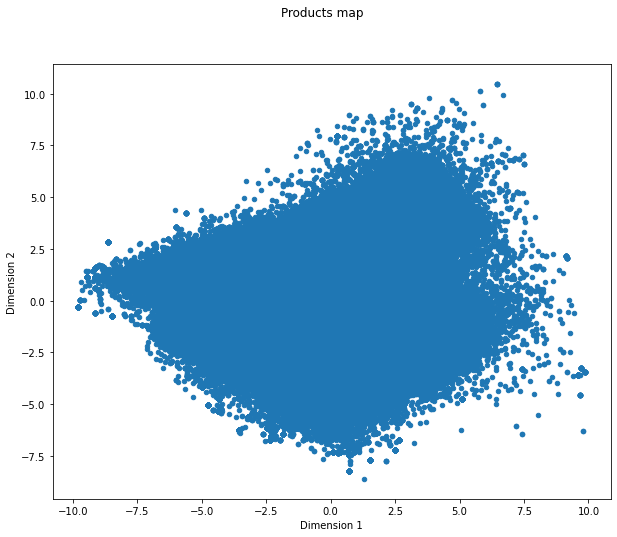

In [69]:
pca_df.plot.scatter("Dim1", "Dim2") #all points
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.suptitle("Products map") # title
fig=plt.gcf()
fig.set_size_inches(10,8)

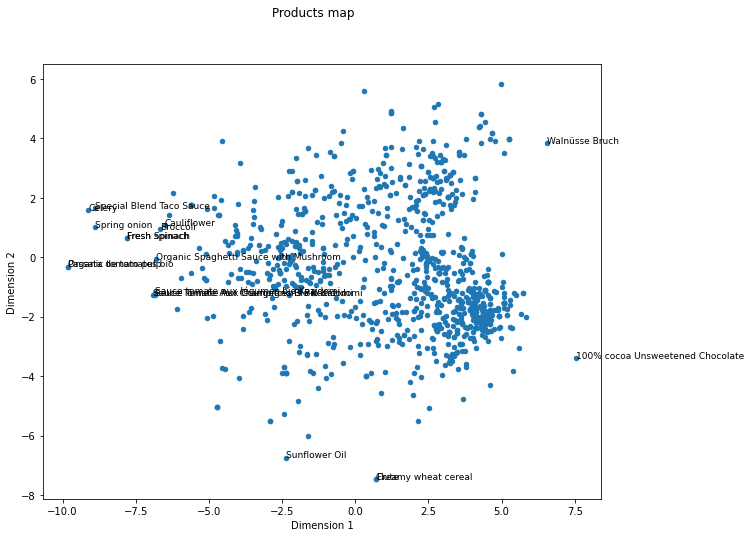

In [72]:
#-- plots with some products names
fig, ax = plt.subplots()
n=1000 # we will plot only first n products because there are too much
pca_df[:n].plot.scatter("Dim1", "Dim2", ax = ax) 

for k in pca_df[:n].iterrows():
    # we annotate only if values on dimensions are importants
    #try:
        if (abs(k[1]['Dim1']) > 6.5) | (abs(k[1]['Dim2']) > 6.5):
                ax.annotate(str(k[1]["product_name"]), (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
    
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.suptitle("Products map")
fig=plt.gcf()
fig.set_size_inches(10,8)

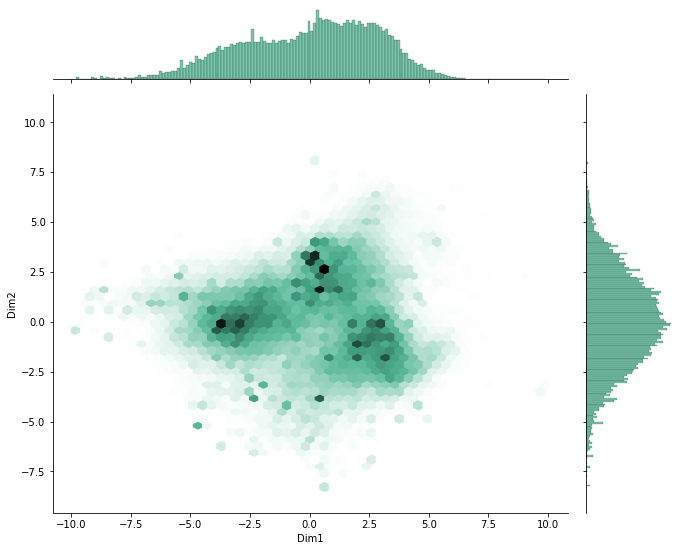

In [70]:
#in order tW eo better visualize densities
sns.jointplot(x=pca_df["Dim1"], y=pca_df["Dim2"], kind="hex", color="#4CB391")
fig=plt.gcf()
fig.set_size_inches(10,8)

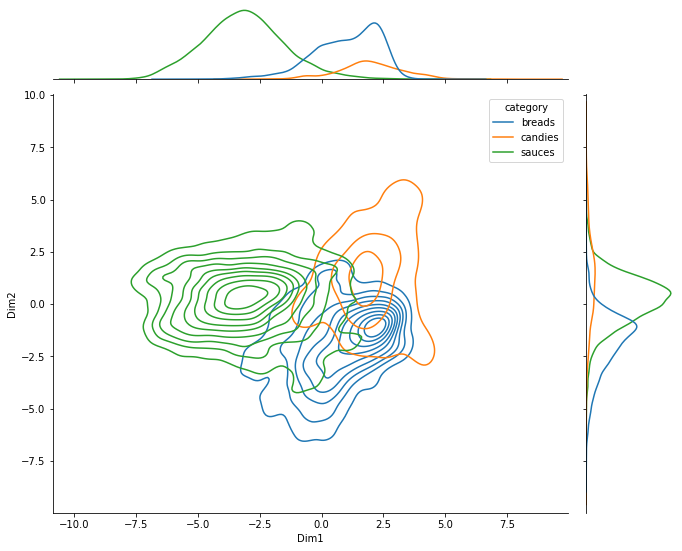

In [71]:
#-- Plot to see similarities beetween product of a same categorie
cat=["candies","breads","sauces"]
temp=pca_df[pca_df["category"].isin(cat)]
sns.jointplot(data=temp, x="Dim1", y="Dim2", hue="category",kind="kde")
fig=plt.gcf()
fig.set_size_inches(10,8)